**Author: Jeyshinee Pyneeandee** May 2024
###### (Based on code/05_Data Availability Plot.ipynb by Marianne) 
This is a script to display the data availability of ISIS 1 Ionograms based on stations and time periods during which data was collected.

In [1]:
#Required imports 
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
import pycountry
import urllib
import PIL

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import dates as mdates
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # Remove Setting with copy warning in pandas

In [66]:
#Helper functions
def get_flag(country):
    flagID = {'USA':'1f1fa-1f1f8',
                  'India':'1f1ee-1f1f3',
                  'South Africa': '1f1ff-1f1e6',
                  'New Zealand': '1f1f3-1f1ff' ,
                  'Congo': '1f1e8-1f1ec',
                  'Burkino Faso': '1f1e7-1f1eb',
                  'Guyana' : '1f1ec-1f1fe',
                  'Finland':'1f1eb-1f1ee',
                 'Antarctica':'1f1fa-1f1f8',
                 'Canada' : '1f1e8-1f1e6',
                 'United Kingdom' : '1f1ec-1f1e7',
                 'Chile' : '1f1e8-1f1f1',
                 'Australia' : '1f1e6-1f1fa',
                 'Ecuador' : '1f1ea-1f1e8',
                 'Spain' : '1f1ea-1f1f8',
                 'Japan' : '1f1ef-1f1f5',
                 'Singapore' : '1f1f8-1f1ec',
                 'Falkland Islands' : '1f1eb-1f1f0',
                 'France' : '1f1eb-1f1f7',
                 'Madagascar' : '1f1f2-1f1ec',
                 'Norway' : '1f1f3-1f1f4',
                 'Peru' : '1f1f5-1f1ea',
                 'Nigeria' : '1f1f3-1f1ec',
                 'Algeria': '1f1e9-1f1ff',
                 '': '1f1eb-1f1ee'}
    url = "https://github.com/twitter/twemoji/blob/master/assets/72x72/"+flagID[country]+".png?raw=true"
    
    response = urllib.request.urlopen(url)
    im = np.asarray(PIL.Image.open(response).convert("RGBA"))
    
    return im

def add_image(coord, country, ax, startDate):
    # Get the image
    img = get_flag(country)
    # Adjust the image
    z=0.21
    im = OffsetImage(img,zoom=z)
    # Define flag axe
    im.image.axes = ax
    # Add the flag the the plot
    flag = AnnotationBbox(im, (mdates.date2num(startDate), coord),  xybox=(-37., 0.), 
                        frameon=False, xycoords='data',  boxcoords="offset points", pad=0)
    ax.add_artist(flag)

In [67]:
def availabilityPlot(results_file,startDate,endDate,title,stationCode='all',cmap='winter_r'):
    '''
    Definition:
       availabilityPlot produces a plot showing the availability of ionograms collected per station, according to the time period given
    
    Parameters:
        results_file: pandas dataframe of ISIS data
        startDate (str): String containing the start date desired, in (yyyymmdd) format
        endDate: String containing the end date desired, in (yyyymmdd) format
        title(str): Title displayed in plot
        stationCode: String or List of Strings containing desired station code (Refer to table below to get station codes). Defaults to all. 
        cmap: Matplotlib colour map, defaults to winter_r

    Return:
        plot showing counts to ionograms per station, per time interval
    
    '''

    time_quality = [1,2,3]
    results_file = results_file.loc[results_file['Time_quality'].isin(time_quality)]

    results_file['Year'] = results_file['Year'].astype(str)
    my_year = results_file['Year']

    results_file['Day'] = results_file['Day'].astype(str)
    day_num = results_file['Day']

    final_date_format = []
    for year, day in zip(my_year, day_num):
        convert_datetime = str(dt.strptime(year + "-" + day, "%Y-%j").strftime("%Y-%m-%d"))
        final_date_format.append(convert_datetime)
    results_file["Timestamp Updated"] = final_date_format
    del final_date_format, my_year
    
    results_file["Timestamp Updated"]=pd.to_datetime(results_file["Timestamp Updated"], format="%Y-%m-%d")
    
    #Filter the data with the dates
    startDate=pd.to_datetime(startDate)
    endDate=pd.to_datetime(endDate)
    subset = results_file.loc[(results_file['Timestamp Updated']>=startDate) & (results_file['Timestamp Updated']<=endDate)]

    # Filter the data with the station code
    if (stationCode != None) & (stationCode != 'all') :
        subset = subset.loc[subset['Station_ID_y'].isin(stationCode)]
    
    subset.reset_index(inplace=True) 

    # Count number of times each stations appear in the document (number of measures per station)
    subset['Station_Frequency'] = subset.groupby('Adjusted_Station_Number')['Adjusted_Station_Number'].transform('count')
    
    # We are only interested in the days, not the hours so we normalize the dates
    subset['Timestamp Updated']=subset['Timestamp Updated'].dt.normalize()

    # For a smaller dataframe, we drop the duplicates
    subset.drop_duplicates(inplace=True)
    subset.sort_values('Station_Frequency', inplace=True, ascending=True)
    
    # Add dates Covered and Not covered by any station
    # Extract the covered dates and sort them
    covered = pd.DataFrame()
    covered['Timestamp Updated'] = subset['Timestamp Updated'].unique()
    if stationCode != None :
        covered['Days_with_data'] = np.repeat('Days with data',len(covered))
    else:
        covered['Days_with_data'] = np.repeat(0.5,len(covered))    
    covered.sort_values(by='Timestamp Updated',inplace=True,ascending=True,ignore_index=True)
    
    # Create empty dataframe
    notcovered = pd.DataFrame(columns=['Timestamp Updated','Days_without_data'])
    # One day measure
    oneday = datetime.timedelta(days=1)
    # For all dates covered
    for i in range(len(covered)-1):
        # Create temporary dataframe
        toadd = pd.DataFrame(columns=['Timestamp Updated','Days_without_data'])
        # Calculate number of days between two dates covered
        interval = (covered['Timestamp Updated'][i+1]-covered['Timestamp Updated'][i])/np.timedelta64(1, 'D')
        # If there's more than one day between two consecutive dates
        if interval > 1. :
            # Add the dates between as not covered
            toadd['Timestamp Updated'] = pd.date_range(covered['Timestamp Updated'][i]+oneday,covered['Timestamp Updated'][i+1]-oneday)
            if stationCode != None :
                toadd['Days_without_data'] = np.repeat('Days without data',len(toadd))
            else:
                toadd['Days_without_data'] = np.repeat(0,len(toadd))
            notcovered = pd.concat([notcovered,toadd],ignore_index=True)  
    
    # Create figure
    fig, ax = plt.subplots()
    fig.suptitle(title)
    # The padding of the figure, we need enough space for the title, colorbar and the station name on the left
    fig.subplots_adjust(top=0.93,bottom=0.2, left=0.3)
    
    # Plot the data availability
    ax.scatter(notcovered['Timestamp Updated'],notcovered['Days_without_data'],marker='|',linewidth=0.7, color='grey')
    ax.scatter(covered['Timestamp Updated'],covered['Days_with_data'],marker='|',linewidth=0.7, color='black')

    if stationCode != None :
        plot = ax.scatter(subset['Timestamp Updated'],subset['Station_Location_y'],c=subset['Station_Frequency'],
                          cmap=cmap,marker='|',linewidth=0.7)
        # Add the colorbar
        cax=fig.add_axes([0.34, 0.067, 0.5, 0.03]) # Colorbar axe
        cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
        cbar.set_label('Number of ionograms between '+startDate.strftime('%Y-%m-%d')+' and '+endDate.strftime('%Y-%m-%d'))
        
        # Add flags
        # Create new dataframe
        stationName = pd.DataFrame()
        # Add the station name and the country for each station
        stationName['Station_Name'] = subset['Station_Location_y']
        stationName['Country'] = subset['Country']
        # Drop the duplicates to only have each station one time
        stationName.drop_duplicates(inplace=True, ignore_index=True)

        # Add the flags to the plot
        if len(notcovered)==0 :
            a = 1
        else :
            a = 2
        for i, c in enumerate(stationName['Country']):
            add_image(i+a, c, ax, startDate)
        
    else :
        ax.set_yticks([0,0.5])
        ax.set_yticklabels(['Days without data','Days with data'])
        ax.set_ylim(-0.15,0.65)
    
    # Add grid and adjust the x and y ticks
    ax.grid(which='major',axis='x',alpha=0.7,lw=0.7,ls='-')
    ax.grid(which='minor',axis='x',alpha=0.7,lw=0.5,ls='--')
    ax.tick_params(which='major',axis='x',labelrotation=90)
    ax.tick_params(which='major',axis='y', pad=26)
    
    # Add the text box for overall days covered
    date_only = subset['Timestamp Updated']
    # The number of unique dates divided by the number of total days
    nbdays = int((endDate-startDate).days+1)
    per = len(date_only.unique()) / nbdays * 100
    text = '% of days with data : '+ "%.2f" % per +'%'
    box = dict(boxstyle='round,pad=0.5', alpha=0.5)
    fig.text(0.13, 0.075, text, va='bottom',bbox=box)
    
    # Custom x ticks
    interval = int((endDate-startDate).days)

    # x ticks vary depending on the interval of time between the start and end dates
    if(interval<=6*4):
        ax.set_xticks(pd.date_range(startDate,endDate,freq='W'),minor=False)
    elif(interval<=18*4):
        ax.set_xticks(pd.date_range(startDate,endDate,freq='MS'),minor=False)
        ax.set_xticks(pd.date_range(startDate,endDate,freq='SMS'),minor=True)
    elif(interval<=36*4):
        ax.set_xticks(pd.date_range(startDate,endDate,freq='MS'),minor=True)
        ax.set_xticks(pd.date_range(startDate,endDate,freq='2MS'),minor=False)
    elif(interval<=60*4):
        xmajor = pd.date_range(startDate,endDate,freq='4MS')
        ax.set_xticks(xmajor, minor=False,)
        ax.set_xticklabels(xmajor.strftime('%Y-%m'), minor=False)
        ax.set_xticks(pd.date_range(startDate,endDate,freq='2MS'),minor=True)
    else:
        xmajor=pd.date_range(str(startDate.year)+'0701',str(endDate.year)+'0701',freq='6MS')
        ax.set_xticks(pd.date_range(startDate,endDate,freq='QS'),minor=True)
        ax.set_xticklabels(xmajor.strftime('%Y-%m'), minor=False)
        ax.set_xticks(xmajor,minor=False)
    
    #return(fig)
    plt.show()


Before using our function, here's a list of the possible station codes and metadata types you can enter as string parameters, for ISIS 1 data.

### Stations

| **Station Code** | Station Name | **Station Code** | Station Name |**Station Code** | Station Name |
|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|
|**TRO**|Tromso, Norway|**ULA**|Fairbanks, Alaska, USA |**WNK**|Winkfield, UK|
|**OTT**|Ottawa, Canada|**AME**|Ahmedabad, India |**ODG**|Ouagadougou, Burkino Faso|
|**KRU**|Kourou, French Guyana|**RES**|Resolute Bay, NT, Canada|**QUI**|Quito, Ecuador|
|**BUR**|Johannesburg, South Africa|**LIM**|Lima, Peru|**AGO**|Santiago, Chile|
|**ORR**|Orroral, Australia|**LAU**|Lauder, New Zealand|**BRET**|Bretigny, France|
|**HAW**|Kauai, Hawaii, USA|**FTM**|Fort Myers, Florida, USA|**HMG**|Colomb Bechar, Algeria|
|**KER**|Kashima, Japan|**MIL**|Merritt Island, Florida, USA|**BLR**|Boulder, Colorado, USA|
|**RAL**|Chilton, UK|**NEW**|St Johns, Canada|


You can also decide the colors of the plot. You can choose a colormap made by matplotlib here or you can create your own. By default, the colormap is winter_r. If we wanted the colors to go from red to purple, here's a way to to it.


In [3]:
colors = ['red','purple','#3d226d']
redpurple = LinearSegmentedColormap.from_list("mycmap", colors)

Finally, you can customize the plot with the following parameters of Matplotlib.


In [4]:
mpl.rcParams['font.family']='Arial' #The font for the whole figure
mpl.rcParams['figure.titlesize']=14 #The title
mpl.rcParams['axes.labelsize']=10 #Title of colorbar axis and plot axis 
                                  #(there is no title for the y-axis and x-axis at the moment)
mpl.rcParams['font.size']=8 #Size of text in box
mpl.rcParams['xtick.labelsize']=10 #Size of the dates on the x-axis and the numbers of the colorbar
mpl.rcParams['xtick.major.size']=6 #Size of major tick lines on the x-axis
mpl.rcParams['xtick.minor.size']=3 #Size of major tick lines on the x-axis
mpl.rcParams['ytick.labelsize']=10 #Size of the station names on the y-axis
mpl.rcParams['ytick.major.size']=6 #Size of tick lines on the y-axis
mpl.rcParams['figure.figsize']=(10,9) #width, height of figure 
                                      #(10 x 9 was the best to display in Jupyter Notebook, 
                                      #but it could be bigger if saved on the computer)

Insert the path of the data you want to plot.

In [32]:
data = ("L:/DATA/ISIS/ISIS_Test_Metadata_Analysis/MERGED/ISIS-1_MD_Version6.csv")

In [33]:
#Reading data
results_file = pd.read_csv(data)

In [63]:
#Fix Antarctica typo and replace certain station names with the country name added
results_file = results_file.replace('Chilton, England', 'Chilton, UK')
results_file = results_file.replace('St Johns, Newfoundland', 'St Johns, Canada')

countries = []
# Create a list of station
stationList = results_file['Station_Location_y'].unique().tolist()
for index, element in enumerate(stationList):
    stationList[index] = element.replace('\xa0','')

#stationList.remove("0")

# For each station, check which country is in the name
for station in stationList :
    for country in pycountry.countries:
        if (country.name in station) | (country.alpha_3 in station) :
            countries.append(country.name)

#Some adjustments because some countries are not detected or are not exactly what we want:
countries.insert(stationList.index('Fairbanks, Alaska'),'USA')
countries.insert(stationList.index('Kauai, Hawaii'),'USA')
countries.insert(stationList.index('Merritt Island, Florida'),'USA')
countries.insert(stationList.index('Ouagadougou, Burkino Faso'),'Burkino Faso')
countries.insert(stationList.index('Boulder, Colorado'),'USA')
countries.insert(stationList.index('Fort Myers, Florida'),'USA')
countries.insert(stationList.index('Winkfield, UK'),'United Kingdom')
countries.insert(stationList.index('Chilton, UK'),'United Kingdom')


results_file['Station_Location_y'] = results_file['Station_Location_y'].str.strip()

#Create the country column
results_file['Country']= ''
for i,station in enumerate(stationList) :
    idx = np.where(results_file['Station_Location_y'] == station)
    results_file['Country'][idx[0]] = countries[i]
results_file.head(10)

,Outlier,Fixed_Frequency_Code,Year,Day,Hour,Minute,Second,Filename,Directory,Subdirectory,...,Station_quality,Station_Location_y,Station_ID_y,Number,Station_Latitude,Station_Longitude,Latitude,Longitude,Station_Location,Country
0,NaN,4,1971,61,16,50,30,Image0002.png,b10_R014207713,B1-34-61 ISIS A C-918,...,1,"Kashima, Japan",KER,70,35.57,140.39,35.6N,140.4E,"Kashima, Japan",Japan
1,NaN,4,1971,61,16,50,59,Image0003.png,b10_R014207713,B1-34-61 ISIS A C-918,...,1,"Kashima, Japan",KER,70,35.57,140.39,35.6N,140.4E,"Kashima, Japan",Japan
2,NaN,4,1971,61,16,51,28,Image0004.png,b10_R014207713,B1-34-61 ISIS A C-918,...,1,"Kashima, Japan",KER,70,35.57,140.39,35.6N,140.4E,"Kashima, Japan",Japan
3,NaN,4,1971,61,16,51,57,Image0005.png,b10_R014207713,B1-34-61 ISIS A C-918,...,1,"Kashima, Japan",KER,70,35.57,140.39,35.6N,140.4E,"Kashima, Japan",Japan
4,NaN,4,1971,61,16,52,26,Image0006.png,b10_R014207713,B1-34-61 ISIS A C-918,...,1,"Kashima, Japan",KER,70,35.57,140.39,35.6N,140.4E,"Kashima, Japan",Japan
5,NaN,4,1971,61,16,52,55,Image0007.png,b10_R014207713,B1-34-61 ISIS A C-918,...,1,"Kashima, Japan",KER,70,35.57,140.39,35.6N,140.4E,"Kashima, Japan",Japan
6,NaN,7,1971,61,16,53,23,Image0008.png,b10_R014207713,B1-34-61 ISIS A C-918,...,1,"Kashima, Japan",KER,70,35.57,140.39,35.6N,140.4E,"Kashima, Japan",Japan
7,NaN,4,1971,61,16,53,52,Image0009.png,b10_R014207713,B1-34-61 ISIS A C-918,...,1,"Kashima, Japan",KER,70,35.57,140.39,35.6N,140.4E,"Kashima, Japan",Japan
8,NaN,4,1971,61,16,54,21,Image0010.png,b10_R014207713,B1-34-61 ISIS A C-918,...,1,"Kashima, Japan",KER,70,35.57,140.39,35.6N,140.4E,"Kashima, Japan",Japan
9,NaN,4,1971,61,16,54,50,Image0011.png,b10_R014207713,B1-34-61 ISIS A C-918,...,1,"Kashima, Japan",KER,70,35.57,140.39,35.6N,140.4E,"Kashima, Japan",Japan


In [64]:
#for roksana: remove when excel file is updated
results_file.drop(results_file.index[results_file['Day'] == '0'], inplace = True)

Fill in the data, desired start date, end date, title and station code in the cell below. 

1320


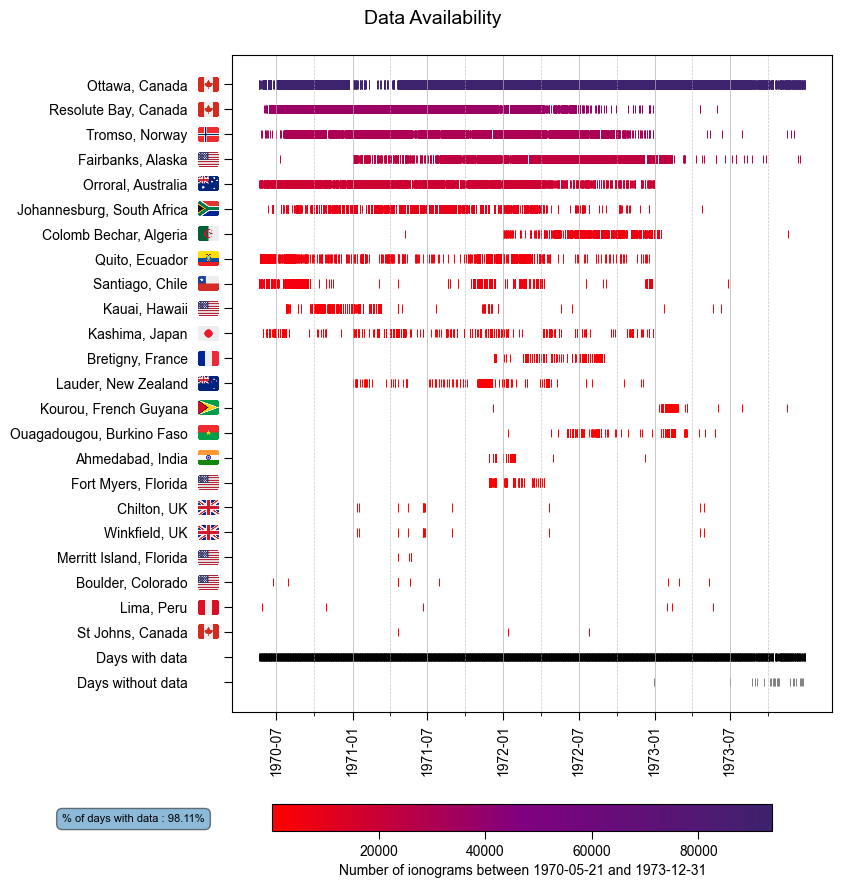

In [65]:
availabilityPlot(results_file = results_file, startDate = "19700521",endDate = "19731231",title = "Data Availability", 
                 stationCode ='all',cmap=redpurple)

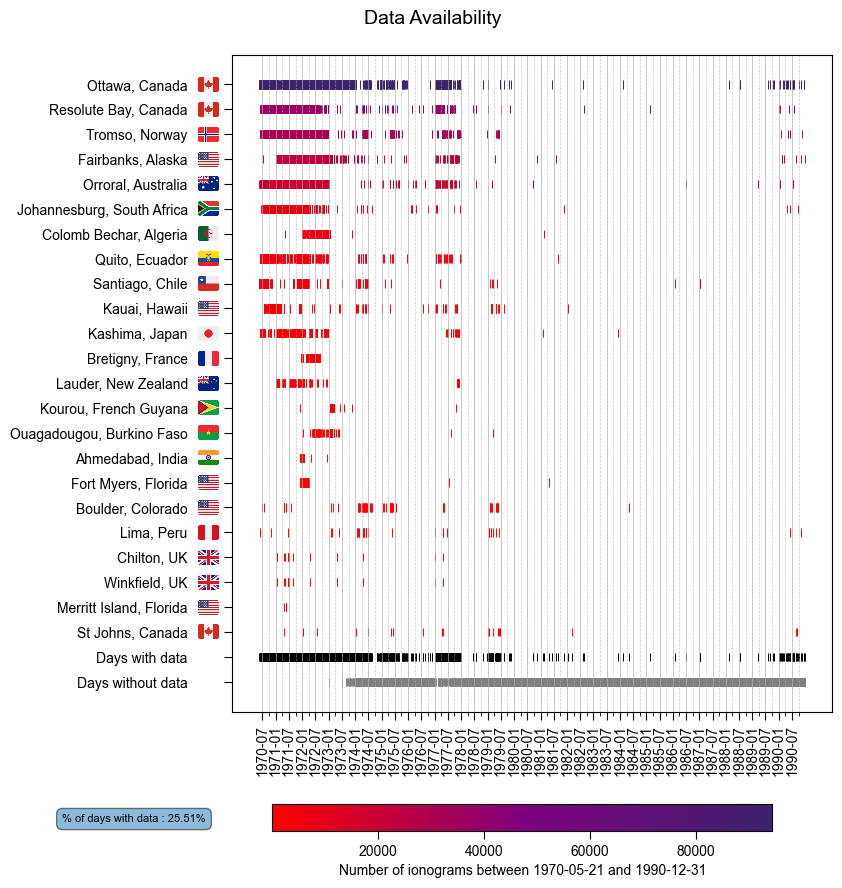

In [68]:
availabilityPlot(results_file = results_file, startDate = "19700521",endDate = "19901231",title = "Data Availability", 
                 stationCode ='all',cmap=redpurple)